In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

%load_ext tensorboard

In [33]:
idg = ImageDataGenerator(rescale=1./255)

train_set = idg.flow_from_directory('chest_xray/train',
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 color_mode='grayscale')

val_set = idg.flow_from_directory('chest_xray/val',
                                          target_size=(150, 150),
                                          batch_size=32,
                                          class_mode='binary',
                                          color_mode='grayscale')

test_set = idg.flow_from_directory('chest_xray/test',
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='binary',
                                            color_mode='grayscale')

Found 5022 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
# Setting paramaters on early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=20,
                          verbose=1,
                          mode='min',
                          restore_best_weights=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [4]:
# Building the model
model1 = models.Sequential()
model1.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='same',
                         activation='relu'))
model1.add(layers.MaxPooling2D(2))
model1.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D(2))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])
model1.summary()

# Fitting the model
history1 = model1.fit(train_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    callbacks=[earlystop]
                    )

In [8]:
model1.evaluate(test_set)

20/20 [==============================] - 18s 936ms/step - loss: 3.1034 - acc: 0.7484 - recall: 0.9949


[3.1034023761749268, 0.7483974099159241, 0.9948717951774597]

In [10]:
# Building the model
second_model = models.Sequential()
second_model.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='valid',
                         activation='relu'))
second_model.add(layers.MaxPooling2D(2))
second_model.add(layers.Conv2D(64, 3, padding='valid', activation='relu'))
second_model.add(layers.MaxPooling2D(2))
second_model.add(layers.Flatten())
second_model.add(layers.Dense(64, activation='relu'))
second_model.add(layers.Dense(32, activation='relu'))
second_model.add(layers.Dense(1, activation='sigmoid'))
second_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])
second_model.summary()

# Fitting the model
history2 = second_model.fit(train_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    callbacks=[earlystop]
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 144, 144, 32)      1600      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                5017664   
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [12]:
second_model.evaluate(test_set)

20/20 [==============================] - 16s 827ms/step - loss: 0.9116 - acc: 0.7676 - recall_1: 0.9897


[0.9116288423538208, 0.7676281929016113, 0.9897435903549194]

In [1]:
# Building the model
third_model = models.Sequential()
third_model.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='valid',
                         activation='relu'))
third_model.add(layers.MaxPooling2D(2))
third_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
third_model.add(layers.MaxPooling2D(2))
third_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
third_model.add(layers.MaxPooling2D(3))
third_model.add(layers.Flatten())
third_model.add(layers.Dense(64, activation='relu'))
third_model.add(layers.Dense(1, activation='sigmoid'))
third_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])
third_model.summary()

# Fitting the model
history3 = third_model.fit(train_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    callbacks=[earlystop, tensorboard_callback]
                    )

NameError: name 'models' is not defined

In [16]:
third_model.evaluate(test_set)

20/20 [==============================] - 15s 767ms/step - loss: 0.7861 - acc: 0.7644 - recall_3: 0.9923


[0.7861124277114868, 0.7644230723381042, 0.9923076629638672]

In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Calculating the class weights
weights = compute_class_weight('balanced', np.unique(train_set.labels),
                               train_set.labels)
# Zipping the class weights into a dictionary
weights = dict(zip(np.unique(train_set.labels), weights))
# Building the model
weighted_model = models.Sequential()
weighted_model.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='same',
                         activation='relu'))
weighted_model.add(layers.MaxPooling2D(2))
weighted_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
weighted_model.add(layers.MaxPooling2D(2))
weighted_model.add(layers.Flatten())
weighted_model.add(layers.Dense(64, activation='relu'))
weighted_model.add(layers.Dense(32, activation='relu'))
weighted_model.add(layers.Dense(1, activation='sigmoid'))
# Compiling the model and looking at the summary
weighted_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.metrics.Recall()])
weighted_model.summary()
# Fitting the model
history3 = weighted_model.fit(train_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    class_weight=weights,
                    callbacks=[earlystop, tensorboard_callback]
                    )

/home/nathaniel/anaconda3/envs/Better-learn/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 32)      1600      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                5607488   
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

In [19]:
weighted_model.evaluate(test_set)

20/20 [==============================] - 16s 811ms/step - loss: 3.2626 - accuracy: 0.7292 - recall_4: 0.9923


[3.2625746726989746, 0.7291666865348816, 0.9923076629638672]

In [36]:
# This is the same as the best previous model with image augmentation
augment_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   horizontal_flip=False,
                                   brightness_range=[.5, 1.5])

augment_set = augment_gen.flow_from_directory('chest_xray/train',
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 color_mode='grayscale')

augmented = models.Sequential()
augmented.add(layers.Conv2D(32, 7, padding='valid', input_shape=(150,150,1), activation='relu'))
augmented.add(layers.MaxPooling2D(2))
augmented.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
augmented.add(layers.MaxPooling2D(2))
augmented.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
augmented.add(layers.MaxPooling2D(3))
augmented.add(layers.Flatten())
augmented.add(layers.Dense(64, activation='relu'))
augmented.add(layers.Dense(1, activation='sigmoid'))
augmented.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])
augmented.summary()

# Fitting the model
historyaug = augmented.fit(augment_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    callbacks=[earlystop, tensorboard_callback])

Found 5022 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 144, 144, 32)      1600      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 36, 36, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_6 (F

In [37]:
augmented.evaluate(test_set)

20/20 [==============================] - 17s 851ms/step - loss: 0.7945 - acc: 0.7276 - recall_6: 0.9923


[0.794464647769928, 0.7275640964508057, 0.9923076629638672]

In [2]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 354621), started 0:10:16 ago. (Use '!kill 354621' to kill it.)

In [29]:
model1.save('First_Model.h5', save_format='h5')
second_model.save('Valid_Padding.h5', save_format='h5')
third_model.save('More_Convolution_Layers.h5', save_format='h5')
augmented.save('Image_Augmentation.h5', save_format='h5')

Found 624 images belonging to 2 classes.
32/32 [==============================] - 8s 238ms/step - loss: 0.2459 - acc: 0.8862 - recall_5: 0.9179


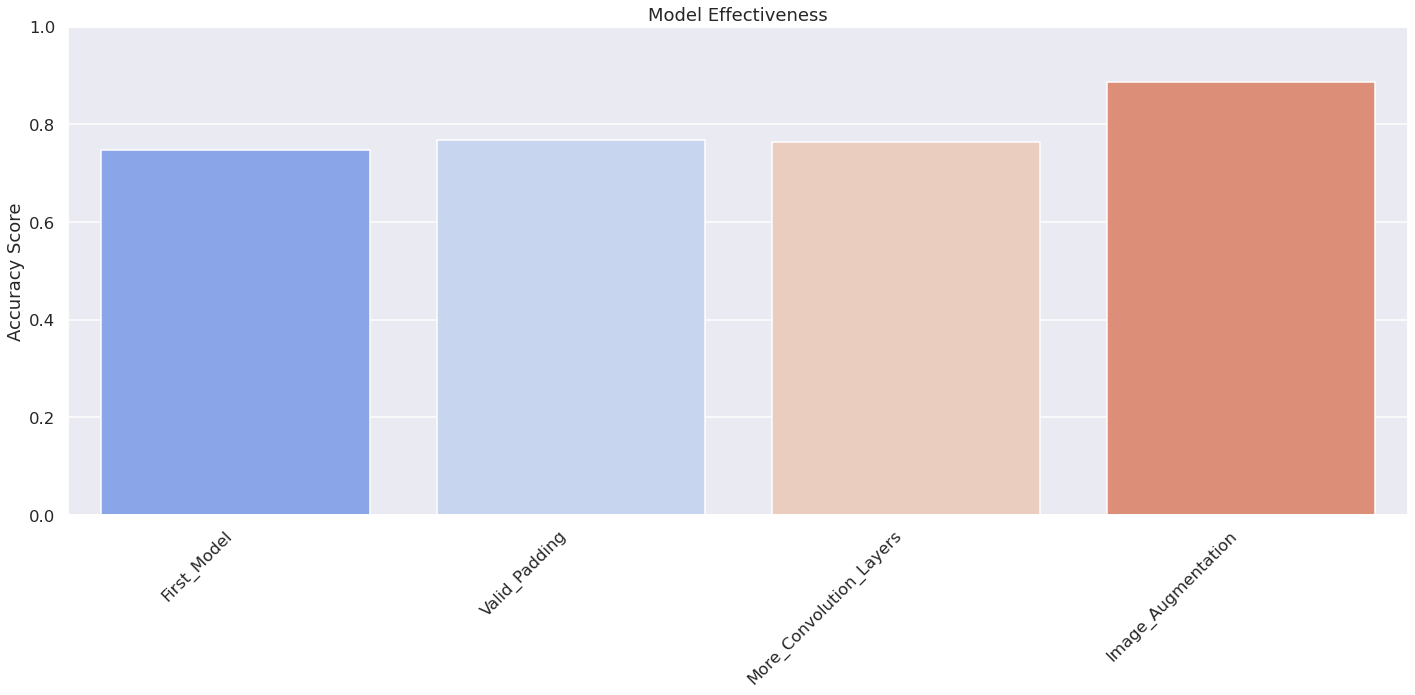

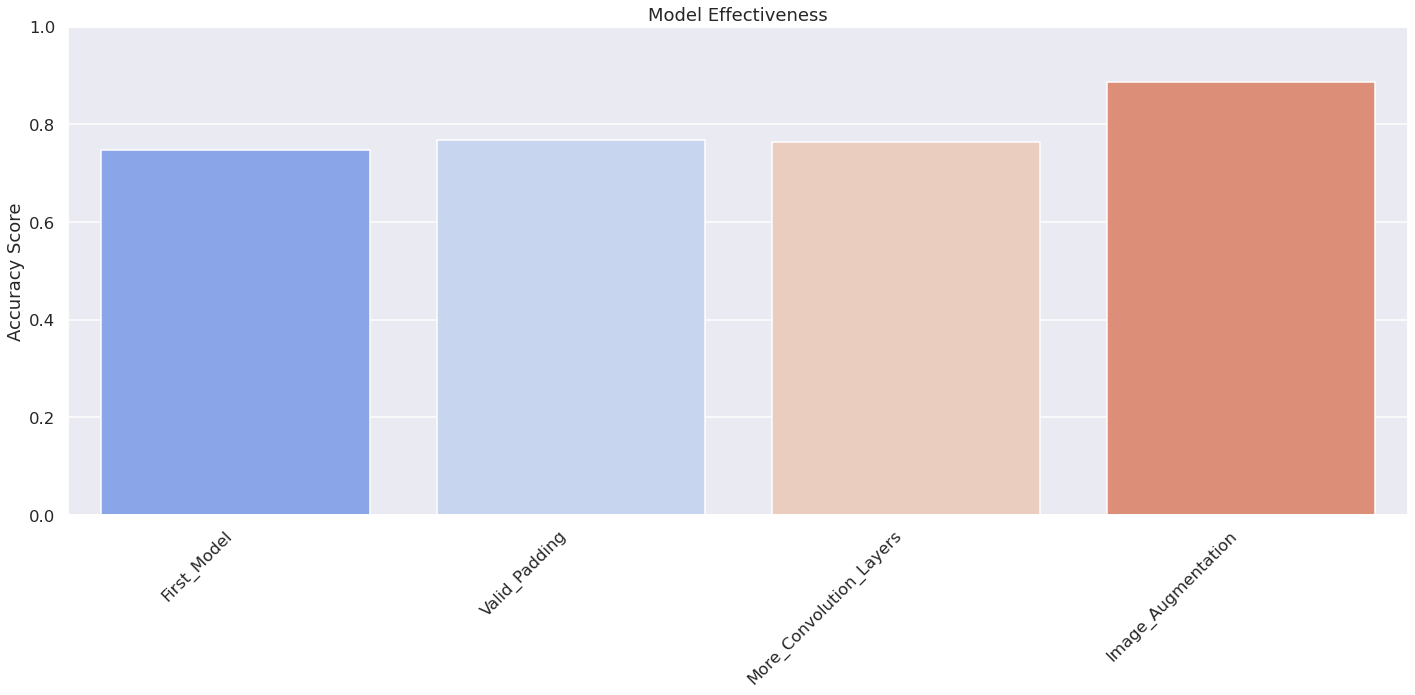

In [28]:
from modelplotting import plot_models

model_list = ['First_Model', 'Valid_Padding', 'More_Convolution_Layers', 'Image_Augmentation']
plot_models(model_list, test_location='chest_xray/test', save_file='Wednesday_Models.png')